# Решение ОДУ

In [1]:
from matplotlib import pyplot as plt


def configure_matplotlib():
    plt.rc('text', usetex=True)
    plt.rcParams["axes.titlesize"] = 28
    plt.rcParams["axes.labelsize"] = 24
    plt.rcParams["legend.fontsize"] = 24
    plt.rcParams["xtick.labelsize"] = plt.rcParams["ytick.labelsize"] = 18
    plt.rcParams["text.latex.preamble"] = r"""
    \usepackage[utf8]{inputenc}
    \usepackage[english,russian]{babel}
    \usepackage{amsmath}
    """

configure_matplotlib()



Подмодуль [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html#module-scipy.integrate) содержит в себе множество методов решения систем обыкновенных дифференциальных уравнений (ОДУ, `ordinary differential equation`, `ODE`).

Т.к. везде ниже будут строиться графики полученного и точного решений уравнения, определим функцию для построения графиков этих решений.

In [14]:
from matplotlib import pyplot as plt


def plot_solution(ax, x, exact_sol, sol_x, sol_y, xlabel="$t$"):
    ax.plot(x, exact_sol(x), color="green", label="Точное решение")
    ax.scatter(sol_x, sol_y, color="red", marker=".", label="Приближенное решение")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("$y$")
    ax.legend()

## Задача Коши

Функция [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) (**solve** **i**nitial **v**alue **p**roblem) позволяет численно решать задачу Коши вида

$$
\begin{cases}
\dfrac{dy}{dt} = f(t, y), \\
y(t_0) = y_0.
\end{cases}
$$

### Уравнение первого порядка

В качестве самого простого примера решим уравнение

$$
\begin{cases}
y' = y, \\
y(0) = 1,
\end{cases}
$$

точное решение которого $y=e^t$. 

Чтобы численно решить это уравнение средствами `SciPy`, необходимо определить функцию правой части (`f(t, y)` в ячейке ниже), задать начальное значение $y(0)$ в виде списка из одного элемента (`y_0` в ячейке ниже), а также задать интервал независимой переменной, на которой необходимо решить дифференциальное уравнение. 

In [20]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt


def f(t, y):
    return y

def exact_solution(t):
    return np.exp(t)

y_0 = [1]
t_0 = 0
t_final = 3
solution = integrate.solve_ivp(f, (t_0, t_final), y_0)
print(solution)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 26
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.10001999, 1.06609106, 2.30431769, 3.        ])
 t_events: None
        y: array([[ 1.        ,  1.10519301,  2.9040598 , 10.01740317, 20.08580546]])
 y_events: None


Метод возвращает структуру со сравнительно большим количеством полей, из которых можно получить отладочную информацию о сходимости алгоритма, а также получить приближенную оценку $\tilde{y}(t)$ в наборе точек $\{t_i,\,i=1,\ldots,n\}$. 

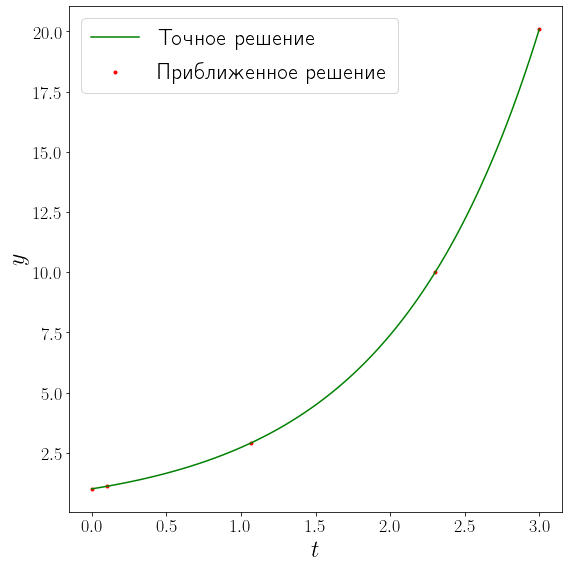

In [21]:
fig, ax = plt.subplots(figsize=(8, 8), layout="tight")
x = np.linspace(t_0, t_final, 100)
plot_solution(ax, x, exact_solution, solution.t, solution.y[0])

```{note}
Хоть правая часть уравнения и не зависит явным образом от $t$, функция `f(t, x)` все равно объявляется с первым параметром `t`.
```

Для данного уравнения функция `scipy.integrate.solve_ivp` выдала решение, содержащее совсем небольшое количество точек, так как метод быстро сошелся. Параметром `t_eval` можно в явно виде задать сетку, в узлах которой требуется получить оценку точного решения.

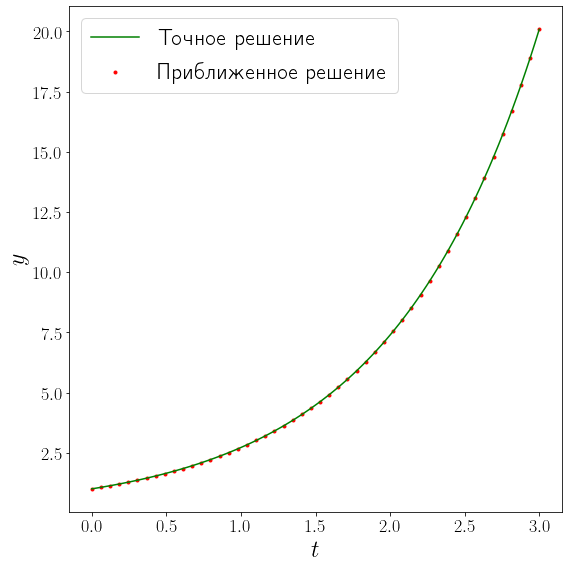

In [23]:
solution = integrate.solve_ivp(f, (t_0, t_final), y_0, t_eval=np.linspace(t_0, t_final, 50))

fig, ax = plt.subplots(figsize=(8, 8), layout="tight")
plot_solution(ax, x, exact_solution, solution.t, solution.y[0])

### Уравнения высшего порядка

Предполагается, что в общем случае $y=y(t)$ является векторной и решается система обыкновенных дифференциальных уравнений.

$$
\begin{cases}
\dot{y}_1 = f_1(t, y_1, \cdots, y_n), \\
\cdots \\
\dot{y}_n = f_n(t, y_1, \cdots, y_n), \\
y_1(t_0) = y_{1,0}, \\
\cdots \\
y_n(t_0) = y_{n,0}.
\end{cases}
$$

Если имеется дифференциальное уравнение высшего порядка разрешенное относительно старшей переменной вида

$$
y^{(n)} = f(t, y, y', \ldots, y^{(n-1)}), 
$$

то необходимо свести его к системе из $n$ уравнение первого порядка.

В качестве примера решим уравнение 

$$
\begin{cases}
z'' + z = 0, \\
z(0) = 0, \\
z'(0) = 1,
\end{cases}
$$

точное решение которого --- $z = \sin t$. Чтобы его решить, необходимо свести уравнение к системе двух дифференциальных уравнений первого порядка. Введём обозначения $y_1(t) = z(t)$ и $y_2(t) = z'(t)$, тогда систему выше можно переписать в виде

$$
\begin{cases}
y_1'(t) = y_2(t), \\
y_2'(t) = -y_1(t), \\
y_1(0) = 0, \\
y_2(0) = 1.
\end{cases}
$$

В таком случае функция правой части уравнения должна принимать на вход вектор $y$ и возвращать вектор производны $y'=f(t, y)$ в виде списка или массива `NumPy`.

In [30]:
def exact_solution(t):
    return np.sin(t)

def f(t, y):
    return [
        y[1], 
        -y[0]
        ]

y_0 = [0, 1]
t_0 = 0
t_final = np.pi
t_eval = np.linspace(0, np.pi, 10)

solution = integrate.solve_ivp(f, (t_0, t_final), y_0, t_eval=t_eval)
print(solution)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 44
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.34906585, 0.6981317 , 1.04719755, 1.3962634 ,
       1.74532925, 2.0943951 , 2.44346095, 2.7925268 , 3.14159265])
 t_events: None
        y: array([[ 0.00000000e+00,  3.42054448e-01,  6.42796558e-01,
         8.66269432e-01,  9.85009559e-01,  9.84744759e-01,
         8.66190242e-01,  6.42630108e-01,  3.41454338e-01,
        -5.87748431e-04],
       [ 1.00000000e+00,  9.39714990e-01,  7.66028577e-01,
         5.00009935e-01,  1.73634556e-01, -1.73906214e-01,
        -5.00472507e-01, -7.66382176e-01, -9.39862784e-01,
        -9.99961909e-01]])
 y_events: None


В решении $y$ тоже возвращается в виде массива из $n$ строк и $m$ столбцов, где $n$ --- порядок системы уравнений, а $m$ --- количество точек, в которых построена оценка решения. В данном примере первая строка массива соответствует искомой зависимости $y_1(t)=z(t)$, а вторая строка --- $y_2(t)$, которая соответствует производной решения $z'(t)$. 

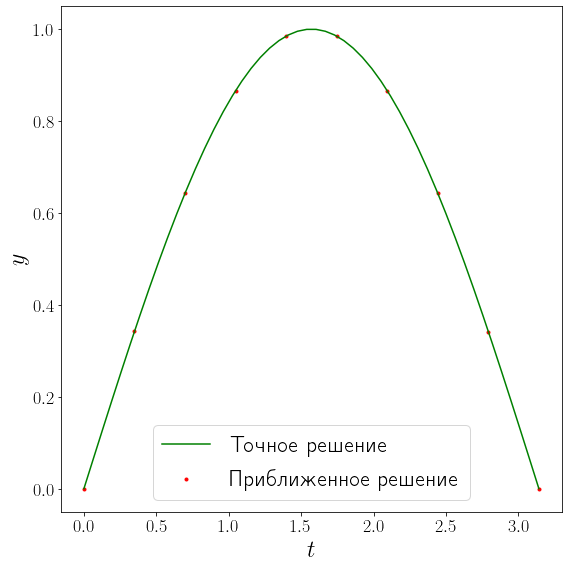

In [32]:
x = np.linspace(0, np.pi, 50)
fig, ax = plt.subplots(figsize=(8, 8), layout="tight")
plot_solution(ax, x, exact_solution, solution.t, solution.y[0])




## Выбор метода решения ОДУ

Решение таких систем ОДУ отнюдь не тривиально. Разработано множество методов их решения и ряд из них "зашит" в подмодуле `scipy.integrate`, среди которых:
- Явные [ме́тоды Ру́нге — Ку́тты](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%A0%D1%83%D0%BD%D0%B3%D0%B5_%E2%80%94_%D0%9A%D1%83%D1%82%D1%82%D1%8B) 2-го (`RK23`), 4-го (`RK45`) и 8-го (`DOP853`) порядков;
- Неявный метод Руне --- Кутты 5-го порядка `Radau`;
- Неявные методы [BDF](https://en.wikipedia.org/wiki/Backward_differentiation_formula) и `LSODA`.

Основным критерием выбора является [жесткость системы ОДУ](https://ru.wikipedia.org/wiki/%D0%96%D1%91%D1%81%D1%82%D0%BA%D0%B0%D1%8F_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0): явные методы плохо проявляют себя на жестких системах. `SciPy` рекомендует использовать по умолчанию метод `RK45` и если он плохо/долго сходится переключаться на метод `Radau` иди `BDF`. 

## Краевая задача

Функция [scipy.integrate.solve_bvp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html#scipy.integrate.solve_bvp) (**solve** **b**oundary **v**alue **p**roblem`) предназначена для решения системы ОДУ с краевыми условиями

$$
\begin{cases}
\dfrac{dy}{dx} = f(x, y), \\
y(a) = y_a, \\
y(b) = y_b.
\end{cases}
$$


В качестве аргументов функция `solve_bvp` принимает: 
- функцию `f`, задающую правую часть уравнения,
- функцию `bc` (**b**oundary **c**ondition), задающую невязку для граничных условий,
- массив `x`, определяющий сетку значений независимой переменной $x$, 
- массив `y`, задающий "догадку" об итоговом решении $y = y(x)$.

Функция `bc` должна принимать на вход $y(a)$ и $y(b)$ (векторные величины в общем случае) и возвращать вектор невязки на граничных условиях.

В качестве примера решим последнюю систему, 

$$
\begin{cases}
z'' + z = 0, \\
z(0) = 0, \\
z(\dfrac{\pi}{2}) = 1,
\end{cases}
$$

но с граничными условиями на отрезке $x \in [0, \frac{\pi}{2}]$. Как и в случае задачи Коши здесь потребуется свести уравнение второго порядка к систему из двух уравнений первого порядка.

$$
\begin{cases}
y_1'(t) = y_2(t), \\
y_2'(t) = -y_1(t), \\
y_1(0) = 0,
y_1(\dfrac{\pi}{2}) = 1.
\end{cases}
$$



  

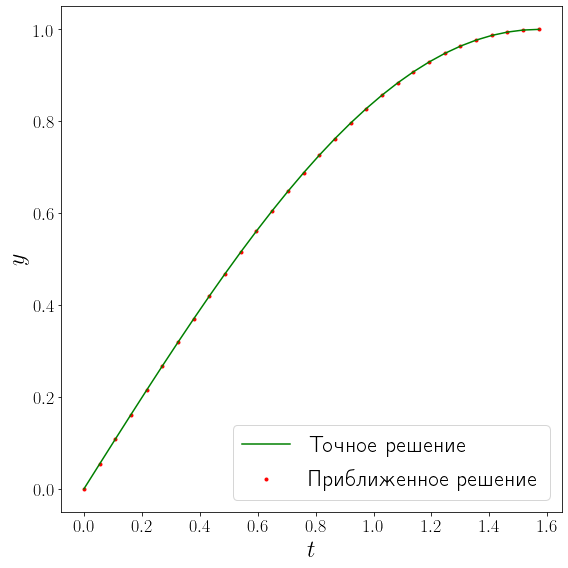

In [37]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt


def boundary_residual(ya, yb):
    return np.array([
        ya[0] - 0, 
        yb[0] - 1
        ]) 


a, b = 0, np.pi/2
N = 30
x = np.linspace(a, b, N)
y_guess = np.zeros((2, N), dtype=float)

sol = integrate.solve_bvp(f, boundary_residual, x, y_guess)

fig, ax = plt.subplots(figsize=(8, 8), layout="tight")
plot_solution(ax, x, exact_solution, sol.x, sol.y[0])